In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add the absolute path to the src directory to sys.path
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)


# Visualize the orderbook over time

In [2]:
# Import functions and libraries
from src.francis.orderbook_plot import plot_orderbook_over_time
from src.francis.orderbook_reconstruction import reconstruct_orderbook_every_tick_with_orders
import pandas as pd
import json

In [25]:
# Reconstruct the orderbook
# Reload the uploaded original CSV file
file_path = "data/orderbook_data.csv"
df = pd.read_csv(file_path, header=None)

# Assign column names
df.columns = ["timestamp", "side", "price", "size", "number_of_orders"]
df = df[df["side"].isin(["bid", "ask"])]
df["timestamp"] = df["timestamp"].astype(float)
df["price"] = df["price"].astype(float)
df["size"] = df["size"].astype(float)

# Sort by timestamp
df = df.sort_values(by="timestamp")


# The original data is too large to visualize, so we take a sample
df_small = df.head(1000000)
sample_orderbook, sample_csv_rows = reconstruct_orderbook_every_tick_with_orders(
    df_small
)

# Save the result to JSON
sample_json_path = "data/reconstructed_orderbook_small.json"
with open(sample_json_path, "w") as f:
    json.dump(sample_orderbook, f)

# Save the result to CSV
sample_df = pd.DataFrame(
    sample_csv_rows, columns=["timestamp", "side", "price", "size", "number_of_orders"]
)

sample_df.to_csv("data/reconstructed_orderbook_small.csv", index=False)




/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_35043/25472299.py:4: DtypeWarning: Columns (0,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=None)


In [6]:
import pandas as pd

# Reload the uploaded original CSV file, letting pandas pick up the header row
file_path = "data/orderbook_data.csv"
df = pd.read_csv(
    file_path,
    header=0,  # ← use the first line as column names
    dtype={"side": str, "price": float, "size": float, "number_of_orders": int}
)

# Keep only bids & asks
df = df[df["side"].isin(["bid", "ask"])]

# Convert UNIX seconds to datetime and index
df["timestamp"] = pd.to_datetime(df["timestamp"].astype(float), unit="s")
df = df.set_index("timestamp").sort_index()

# Resample into 1‑time bins
bids = (
    df[df["side"] == "bid"]
    .resample("1S")
    .agg(
        bid_orders=("number_of_orders", "sum"),
        best_bid=("price", "max")
    )
)
asks = (
    df[df["side"] == "ask"]
    .resample("1S")
    .agg(
        ask_orders=("number_of_orders", "sum"),
        best_ask=("price", "min")
    )
)

# Combine and compute mid‑price
per_time = pd.concat([bids, asks], axis=1)
per_time["mid_price"] = (per_time["best_bid"] + per_time["best_ask"]) / 2
per_time = per_time.dropna(subset=["mid_price"])  # drop any time missing one side

# Write out to CSV
per_time.to_csv("data/reconstructed_orderbook_by_time.csv", index_label="timestamp")


/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_37019/1178261975.py:21: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("1S")
/var/folders/db/919qzgb17qx_tyqb0qbkngmm0000gn/T/ipykernel_37019/1178261975.py:29: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  .resample("1S")


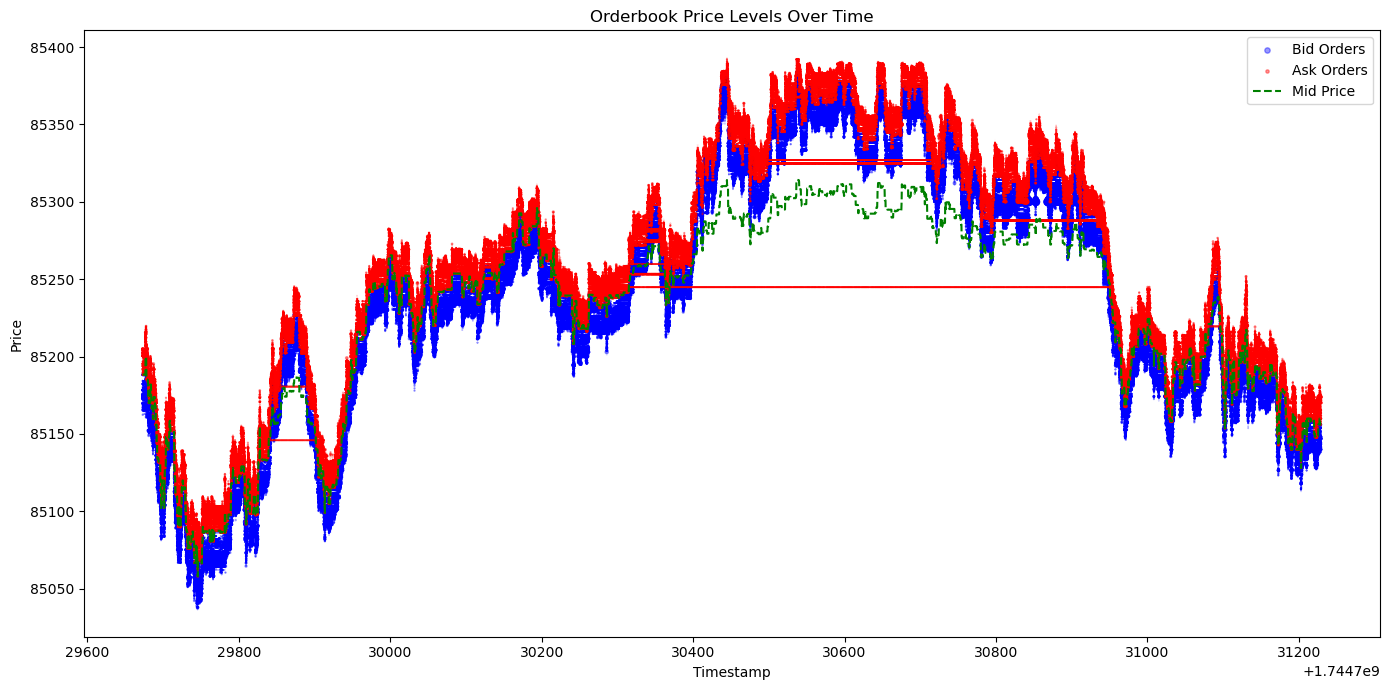

In [27]:

orderbook = pd.read_csv("data/reconstructed_orderbook_small.csv")
plot_orderbook_over_time(orderbook)


In [6]:
book = oba.loadReconstructedOrderbook("data/reconstructed_orderbook_by_time.csv")
print(book.index.min(), "→", book.index.max())
print("Total seconds:", (book.index.max() - book.index.min()).total_seconds())


2025-04-15 15:07:52 → 2025-04-15 16:16:30
Total seconds: 4118.0


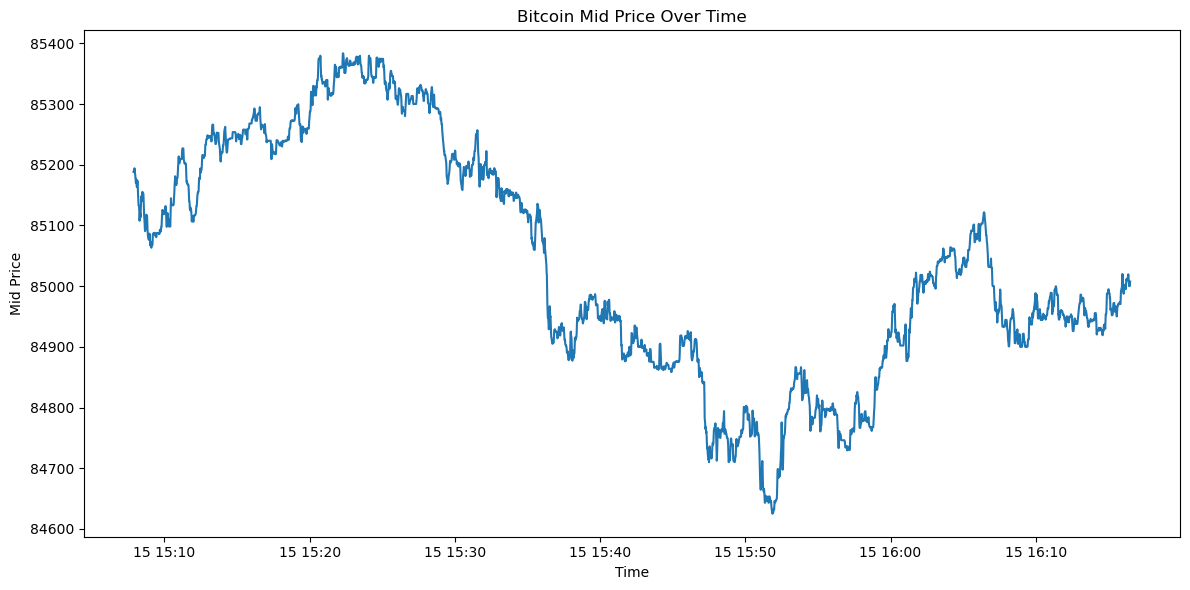

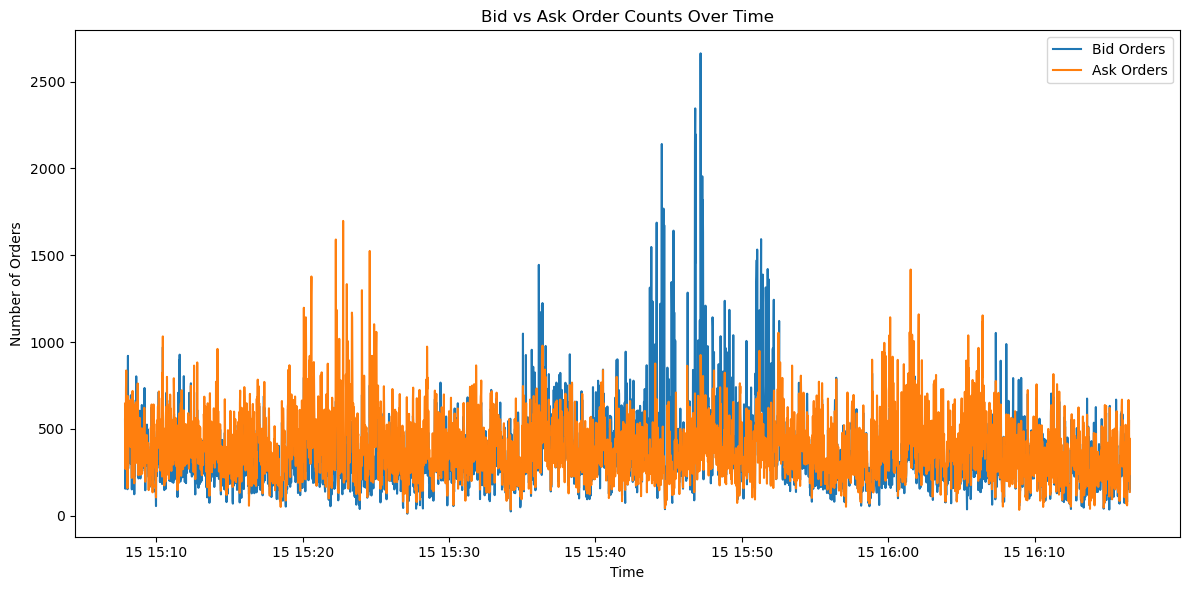

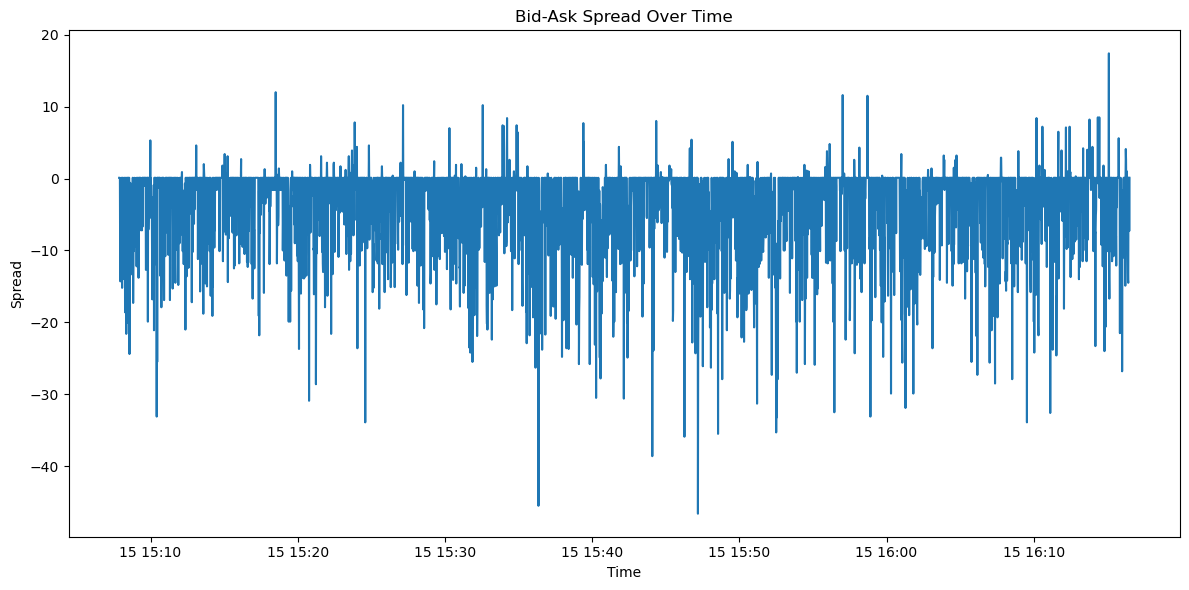

             startTime             endTime  drop_amount
0  2025-04-15 15:08:32 2025-04-15 15:08:37        41.35
1  2025-04-15 15:31:32 2025-04-15 15:31:37        40.85
2  2025-04-15 15:31:33 2025-04-15 15:31:38        41.05
3  2025-04-15 15:31:34 2025-04-15 15:31:39        43.05
4  2025-04-15 15:31:35 2025-04-15 15:31:40        43.90
..                 ...                 ...          ...
56 2025-04-15 16:01:02 2025-04-15 16:01:07        48.65
57 2025-04-15 16:01:45 2025-04-15 16:01:50        41.10
58 2025-04-15 16:01:46 2025-04-15 16:01:51        39.35
59 2025-04-15 16:08:28 2025-04-15 16:08:33        40.00
60 2025-04-15 16:11:30 2025-04-15 16:11:35        40.60

[61 rows x 3 columns]


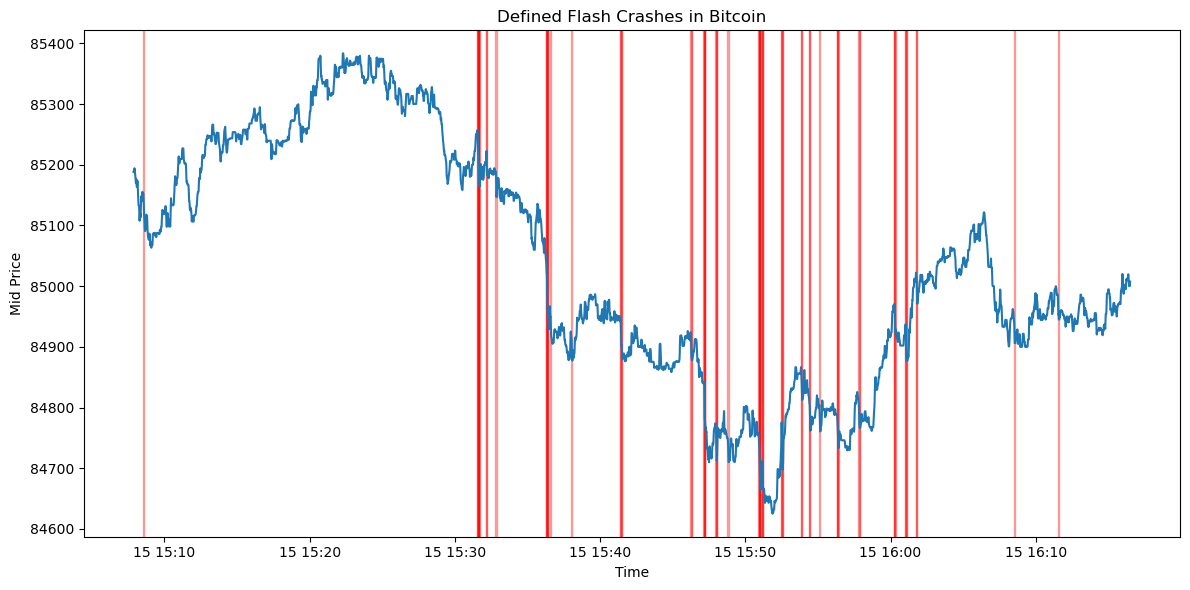

In [7]:
from src.tim import orderbook_analysis as oba

# load the per-second file
book = oba.loadReconstructedOrderbook("data/reconstructed_orderbook_by_time.csv")

# visualize
oba.plotMidPrice(book)
oba.plotOrderCounts(book)
oba.plotSpread(book)

# rolling 5‑second crash detection
crashes = oba.detectFlashCrashesRolling(book,
                                        thresholdRangePct=0.05,
                                        windowSeconds=5)
print(crashes)
oba.plotFlashCrashes(book, crashes)


# Label the Training Data
Since our goal is to predict the crash, we need to label the training data as 1, -1 if the large move happens, and 0 otherwise.







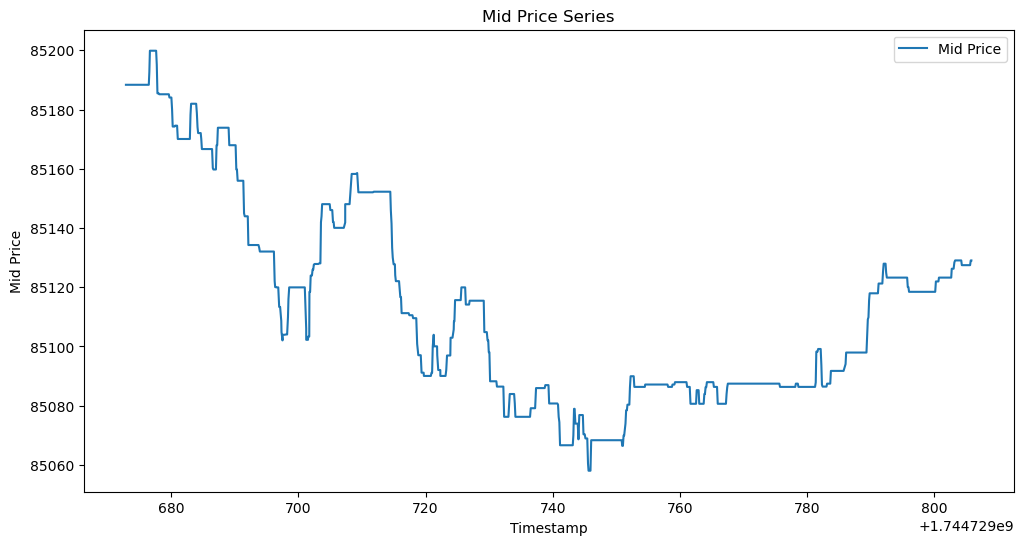

In [6]:
from src.francis.label_data_n_horizon import prepare_training_data_fullbook_future_label
from src.francis.label_data_full_book import prepare_training_data_full_book
from src.francis.label_data_partial_book import prepare_training_data_partial_book
from src.francis.mid_price_extract import extract_mid_prices

In [7]:
mid_df = extract_mid_prices("data/reconstructed_orderbook_small.csv")
mid_df.to_csv("data/mid_price_small.csv", index=False)

In [8]:
df = prepare_training_data_full_book(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00002)


df.to_csv("data/training_data_full_book_small.csv", index=False)


In [9]:
df = prepare_training_data_partial_book(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00002,
                                      top_n=5)


df.to_csv("data/training_data_partial_book_small.csv", index=False)



In [10]:
df = prepare_training_data_fullbook_future_label(orderbook_csv="data/reconstructed_orderbook_small.csv",
                                      mid_price_csv="data/mid_price_small.csv",
                                      threshold=0.00005,
                                      horizon=20)


df.to_csv("data/training_data_fullbook_future_label_small.csv", index=False)


🧾 Dataset Info
Rows: 1304  |  Columns: 4
Column Types:
timestamp    float64
bids          object
asks          object
label        float64
dtype: object
--------------------------------------------------
📅 Timestamp Range
From 1744729672.889366 to 1744729805.733907
--------------------------------------------------
📊 Label Distribution
label
-1.0    441
 1.0    433
 0.0    430
Name: count, dtype: int64
--------------------------------------------------
Orderbook Depth
Avg # of bids: 50.00  |  Max: 50
Avg # of asks: 50.00  |  Max: 50
--------------------------------------------------


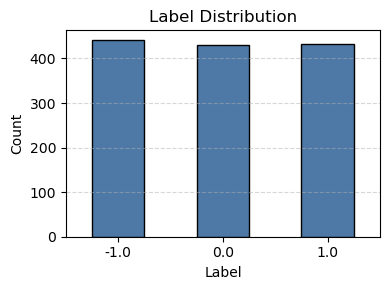

In [12]:

# Basic Info
print("🧾 Dataset Info")
print(f"Rows: {df.shape[0]}  |  Columns: {df.shape[1]}")
print("Column Types:")
print(df.dtypes)
print("-" * 50)

# Timestamp Range
print("📅 Timestamp Range")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")
print("-" * 50)

# Label Distribution
print("📊 Label Distribution")
print(df["label"].value_counts(dropna=False))
print("-" * 50)

# Orderbook Depth
bid_lens = df["bids"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))
ask_lens = df["asks"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x))

print("Orderbook Depth")
print(f"Avg # of bids: {bid_lens.mean():.2f}  |  Max: {bid_lens.max()}")
print(f"Avg # of asks: {ask_lens.mean():.2f}  |  Max: {ask_lens.max()}")
print("-" * 50)

# Label Visualization
plt.figure(figsize=(4, 3))
df["label"].value_counts().sort_index().plot(kind="bar", color="#4e79a7", edgecolor="black")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()